In [1]:
#Note that I'll likely re-visit all of these steps when I've collcted more data. However, for the present we'l start with this

#I wonder if I should make a separate one for anime. I guess we'll find out.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [2]:
manga_table = pd.read_csv('data/manga_table_i.csv') #Starting with my initial two pulls.
anime_table = pd.read_csv('data/anime_table_i.csv')
print(manga_table.shape, anime_table.shape)
manga_table.head() #On the topic: Future data I plan on also grabbing the flair. But for now...
#Not that I even ended up using it - even in this current iteration.

(986, 6) (1010, 6)


,title,selftext,over_18,subreddit,time,id
0,Y'all Know What This Font Is? \\ Kagurabachi c...,NaN,False,manga,1.705890e+09,19cko5o
1,Trying to find a manhwa/manhua but I cant reme...,I am trying to find a manga where the mc is a...,False,manga,1.705889e+09,19ckgrg
2,[DISC] Tower of God - Season 3 Episode 178,NaN,False,manga,1.705889e+09,19ckf2s
3,[ART] - Tatsuya Endo's illustration for Chapte...,NaN,False,manga,1.705888e+09,19ck611
4,Is the artist from “sono mono nochi ni” the sa...,NaN,False,manga,1.705888e+09,19ck1j5


In [4]:
anime_table.head() #Oh, that's awkward.... must have messed up with my syntax when importing. 
#Anyways, that's obviously a mistake. Furthermore I base my mistaken on not only the first entry's title... but domain 
#knowldge with the fourth. Plus, I just googled the first one's id and it's in R/anime...

#Sure enough, my current code, which I may change ONLY FOR THE SAKE OF CONDENSING my data pulling to one
#'organized' document, has in it:'subreddit':my_subreddit_1, for the anime section, which was previously defined as
#'my_subreddit_2'.... Gah... regardless.

,title,selftext,over_18,subreddit,time,id
0,Having trouble finding Anime to watch with my ...,I started her with Death Note cause she loves ...,False,manga,1.705894e+09,19cm3ep
1,Yuuki Bakuhatsu Bang Bravern (Bang Brave Bang ...,NaN,False,manga,1.705893e+09,19cls7i
2,waifu 3x3. lets start a war!,[my 3x3 no order](https://imgur.com/a/nXsWUai)...,False,manga,1.705893e+09,19clr6w
3,「Jaku-Chara Tomozaki-kun 2nd STAGE」WEB Preview...,NaN,False,manga,1.705893e+09,19cln1f
4,My Thoughts on season 1 of hibike euphonium.,These are my thoughts on season 1 without the ...,False,manga,1.705893e+09,19clmrv


In [8]:
#Note, on that topic is something quite interesting - the timing of things. Likely this is true for all matters and discussions,
#but there is often a preference to discuss whatever is new. Perforce, with other data, albit not provided for us,
#one could trace 'current events' to posts. Ie it makes a lot of sense for 'Jakua-Chara Tomozaki-kun'/'Bottom-tier
#Tomozaki' to be discussed as the new anime season just came out two weeks ago. Now, likely that will bring with it
#revived interest in the manga,but pragmatically....

#And, on that topic: lower numbers are potentially more significant to animes as often the number of seasons with each one
#are lower than the accompany 'comic-book' like format associated with manga [conversion rates vary, but for
#an incredibly rough translation let's say 3ish (domain knowledge)]. Interestingly, a 2-gram might not pick this up as 'kun'
#is a Japanese honorific for a younger male (generally), however 'Tomozaki-2nd', or the current 3-gram of
#'Tomozaki-kun-2nd' would be significant.... however that is only imbuing with it domain knowledge - which the computer
#does not have.

In [5]:
anime_table['subreddit'] = 'anime'
anime_table.head()

,title,selftext,over_18,subreddit,time,id
0,Having trouble finding Anime to watch with my ...,I started her with Death Note cause she loves ...,False,anime,1.705894e+09,19cm3ep
1,Yuuki Bakuhatsu Bang Bravern (Bang Brave Bang ...,NaN,False,anime,1.705893e+09,19cls7i
2,waifu 3x3. lets start a war!,[my 3x3 no order](https://imgur.com/a/nXsWUai)...,False,anime,1.705893e+09,19clr6w
3,「Jaku-Chara Tomozaki-kun 2nd STAGE」WEB Preview...,NaN,False,anime,1.705893e+09,19cln1f
4,My Thoughts on season 1 of hibike euphonium.,These are my thoughts on season 1 without the ...,False,anime,1.705893e+09,19clmrv


In [10]:
#So yeah, just from the head we see two interesting things:
#The first is 4/5 nans in just the selftext... likely those are pictures that we do not wish to explore for this
#iteration of the project. We'll do a count momentarily.
#Secondly, we already see a lot of Japanese.... besides the language gap, despite my experience, there will be not only
#so many more stop words, but will likely be now so many more proper names, many of whom not capitalized, to make noise.
#Thirdly, somewhat tangentially, will be spelling errors...
#Fourthly will be the treatment of numbers... potentially relevant to certain things, likely in combination with things
#ie episode... and alredy note in the third entry - we alrady have language that belongs to do 'anime' section seemingly...
    #On the topic, we will need to be wary of emojis,etc... pragmatically we'll likely have enough data to just ignore them.

#Pragmatically, we'll need to use Google translator a lot... for my sake and for the reader. But, for now, let us continue.

In [6]:
manga_table.isnull().sum() #Thankfully just the self text... but wow... over half in manga's text are just imagines...
#Yeah, at least in this subreddit very glad we'll be banking on the comments.

#Tangential: Back in the day when I ran comments, apparently no nulls in the 10kish manga comments... perhaps only the
#poster is able to make images and the like... I am unsure.

title          0
selftext     538
over_18        0
subreddit      0
time           0
id             0
dtype: int64

In [7]:
anime_table.isnull().sum() #Oh, this is interesting - much less nulls in the anime section... Besides having more words
#likely a difference in the two very similar things...

title          0
selftext     155
over_18        0
subreddit      0
time           0
id             0
dtype: int64

In [8]:
#Now we'll start importing the second wave of Reddit day, gathered last night:
mt2 = pd.read_csv('data/manga_table_ii.csv')
mt3 = pd.read_csv('data/manga_table_iii.csv')
at2 = pd.read_csv('data/anime_table_ii.csv')
print(mt2.shape, mt3.shape, at2.shape) #Oh yes, recall that we added flair - so we'll add that to the initial merge...well, it'll
#get accounted for later.
mt2.isnull().sum(), mt3.isnull().sum(), at2.isnull().sum() #Unsurprisingly the trend of more nulls in manga...

(317, 7) (324, 7) (800, 7)


(title          0
 flair        137
 selftext     162
 over_18        0
 subreddit      0
 time           0
 id             0
 dtype: int64,
 title          0
 flair        152
 selftext     167
 over_18        0
 subreddit      0
 time           0
 id             0
 dtype: int64,
 title          0
 flair          0
 selftext     120
 over_18        0
 subreddit      0
 time           0
 id             0
 dtype: int64)

In [9]:
#Round III of extra tables:
mt4 = pd.read_csv('data/manga_table_iv.csv')
at4 = pd.read_csv('data/anime_table_iv.csv')
print(mt4.shape, at4.shape)
mt4.isnull().sum(), at4.isnull().sum() #Same trends as before. Nothing new to comment.

(992, 7) (963, 7)


(title          0
 flair        440
 selftext     516
 over_18        0
 subreddit      0
 time           0
 id             0
 dtype: int64,
 title          0
 flair          0
 selftext     140
 over_18        0
 subreddit      0
 time           0
 id             0
 dtype: int64)

In [12]:
#Round IV of extra tables:
mt5 = pd.read_csv('data/manga_table_v.csv')
at5 = pd.read_csv('data/anime_table_v.csv')
print(mt5.shape, at5.shape)
mt5.isnull().sum(), at5.isnull().sum()

(960, 7) (965, 7)


(title          0
 flair        385
 selftext     543
 over_18        0
 subreddit      0
 time           0
 id             0
 dtype: int64,
 title          0
 flair          0
 selftext     139
 over_18        0
 subreddit      0
 time           0
 id             0
 dtype: int64)

In [13]:
#And, finally I hope we're done, round V:
mt6 = pd.read_csv('data/manga_table_vi.csv')
at6 = pd.read_csv('data/anime_table_vi.csv')
print(mt6.shape, at6.shape)
mt6.isnull().sum(), at6.isnull().sum()

(985, 7) (960, 7)


(title          0
 flair        425
 selftext     524
 over_18        0
 subreddit      0
 time           0
 id             0
 dtype: int64,
 title          0
 flair          0
 selftext     131
 over_18        0
 subreddit      0
 time           0
 id             0
 dtype: int64)

In [14]:
#Before we continue, let us confirm that we didn't mess up (again) on the data gathering and get
#multiple rows or the like:
#Given that I want to have an equal number of animes and mangas, we'll make them both seperate then combine:
manga_lord = pd.concat([manga_table, mt2, mt3, mt4, mt5, mt6])
manga_lord = manga_lord.reset_index(drop=True)
print(manga_lord.shape)
manga_lord.head()

(4564, 7)


,title,selftext,over_18,subreddit,time,id,flair
0,Y'all Know What This Font Is? \\ Kagurabachi c...,NaN,False,manga,1.705890e+09,19cko5o,NaN
1,Trying to find a manhwa/manhua but I cant reme...,I am trying to find a manga where the mc is a...,False,manga,1.705889e+09,19ckgrg,NaN
2,[DISC] Tower of God - Season 3 Episode 178,NaN,False,manga,1.705889e+09,19ckf2s,NaN
3,[ART] - Tatsuya Endo's illustration for Chapte...,NaN,False,manga,1.705888e+09,19ck611,NaN
4,Is the artist from “sono mono nochi ni” the sa...,NaN,False,manga,1.705888e+09,19ck1j5,NaN


In [15]:
#To build suspense, like they do in that medium, we'll make the anime first:
anime_lord = pd.concat([anime_table, at2, at4, at5, at6])
anime_lord = anime_lord.reset_index(drop=True)
#anime_lord.drop(['index'], axis = 1)
print(anime_lord.shape)
anime_lord.head()

(4698, 7)


,title,selftext,over_18,subreddit,time,id,flair
0,Having trouble finding Anime to watch with my ...,I started her with Death Note cause she loves ...,False,anime,1.705894e+09,19cm3ep,NaN
1,Yuuki Bakuhatsu Bang Bravern (Bang Brave Bang ...,NaN,False,anime,1.705893e+09,19cls7i,NaN
2,waifu 3x3. lets start a war!,[my 3x3 no order](https://imgur.com/a/nXsWUai)...,False,anime,1.705893e+09,19clr6w,NaN
3,「Jaku-Chara Tomozaki-kun 2nd STAGE」WEB Preview...,NaN,False,anime,1.705893e+09,19cln1f,NaN
4,My Thoughts on season 1 of hibike euphonium.,These are my thoughts on season 1 without the ...,False,anime,1.705893e+09,19clmrv,NaN


In [16]:
#Fine, let's do it, check for duplicates:
print(manga_lord[manga_lord['id'].duplicated()]['subreddit'].value_counts())
print(anime_lord[anime_lord['id'].duplicated()]['subreddit'].value_counts())
#Oooh, that's tough to see... 782 duplicates.... Well, recall that we can still keep a unique value
#from them, so we'd still probably have 3200... let's do just that.
#Oh wait, I'm way overthinking this - let's just use unique...

#Gah.... still a bit shy of manga; wait a bit longer and will be fine...
#Anime, however,would still need two more pulls at the rate we'e going...

subreddit
manga    293
Name: count, dtype: int64
subreddit
anime    1266
Name: count, dtype: int64


In [19]:
print(len(manga_lord['id'].unique()))
print(len(anime_lord['id'].unique()))

4271
3432


In [44]:
len(anime_lord['id'].unique()) #Oh, I guess the duplicated takes into account keeping at least
#one of them... well, worth a try. Well, I want at least 3k, and might as well make it an
#Even 3.5k....so guess we'll wait another week... well, at least do a bit more
#progress tonight and spruce up the data gathering's formula

2956

In [41]:
anime_lord[anime_lord['id'].duplicated()].reset_index().iloc[0]['id'] #We'll focus on this one.

'19bjifp'

In [45]:
anime_lord[anime_lord['id']=='19bjifp']

,title,selftext,over_18,subreddit,time,id,flair
200,What should I watch!!,"I really like anime and adult cartoons, I’ve w...",False,anime,1.705778e+09,19bjifp,NaN
300,What should I watch!!,"I really like anime and adult cartoons, I’ve w...",False,anime,1.705778e+09,19bjifp,NaN


In [ ]:
#Before we continue, let us confirm that we didn't mess up (again) on the data gathering and get
#multiple rows or the like:
df[df['id'].duplicated()]['subreddit'].value_counts()

In [16]:
#Note that for the original two tables we did not yet have a flair column, which we will not be using for the first iteration
#of this project. However, I'd like to go ahead and make it anyways [superfluos??]

In [13]:
#Let's get an exactly even amount of of anime and manga. So, re. anime we will simply use the first 'n' rows from the second
#dataset, assuming a normal distribution of post size.

#Now that we also have at4, with the interesting case of manga being longer, we'll take all of anime 4 and supplement it with
#with rest of anime 2. Reminder that the third round tables were compiled 1/31/24 - 10sih days later. We're still in the
#mdidle of an anime season so we should be fine [another 8ish weeks for Winter 2024 anime; don't think such trends exist by
#manga].
animies_needed = manga_table.shape[0] + mt2.shape[0] + mt3.shape[0] + mt4.shape[0] - anime_table.shape[0] - at4.shape[0]
animies_needed

646

In [14]:
#So, we'll take the first 617 from the second anime table; eh, second and later iterations just use the variable name...
at2 = at2.iloc[0:animies_needed]
at2.shape

(646, 7)

In [15]:
#Anyways, we'll be adding the title to them all, so let's go ahead and combine them:
df = pd.concat([manga_table, mt2, mt3, mt4, anime_table, at2, at4])
df = df.reset_index(drop=True)
#df.drop(['index'], axis = 1)
df.shape

(5238, 7)

In [40]:
df[df['id'].duplicated()]['subreddit'].value_counts() #Gf me....I wonder if I went the wrong direction whenI was doing this...

subreddit
anime    699
Name: count, dtype: int64

In [ ]:
#Hmm.... so we have 2619 good mangas. We have whatevr number good animes - for simple math we have 2k....
#So, we'll wait another 5 days at the moment before continuing... go fr 3k each..... gah.gf me. Honestly, could do it now
#but on principal...

In [ ]:
mangmangmang

In [22]:
df.isnull().sum()  #Unsuprisingly high amounts of flair nulls, as we didn't correct them in our original data pulls.
#Plus, the other two manga pulls had about 300 nulls for them. Regardless, for another iteration of this project it may
#be useful to analyze flairs. Regardless, we continue.

title           0
selftext     1115
over_18         0
subreddit       0
time            0
id              0
flair        2285
dtype: int64

In [23]:
#Yeah, look below - while over half of the mangas are null, only 15% of animes are. See below.
print(df[df['subreddit']=='manga']['selftext'].isnull().sum(), df[df['subreddit']=='manga']['selftext'].isnull().sum()/df[df['subreddit']=='manga']['selftext'].isnull().count())
print(df[df['subreddit']=='anime']['selftext'].isnull().sum(), df[df['subreddit']=='anime']['selftext'].isnull().sum()/df[df['subreddit']=='anime']['selftext'].isnull().count())

867 0.5328826060233559
248 0.1524277811923786


In [24]:
#Bottom line, the current decision is to make a new column, joining together title, assuming significace in that (plus a way
#to deal with all of those nulls...). Note that we will do this to all things, as all posts have a title [likly].
#Pragmatically, when we later look at average word count, albeit not counting images and the like, we'd expect manga
#to be less [a bit ironic considering it's the written version...].
df = df.fillna("")
df['post'] = df['title'] + " " + df['selftext']
df.head()

,title,selftext,over_18,subreddit,time,id,flair,post
0,Y'all Know What This Font Is? \\ Kagurabachi c...,,False,manga,1.705890e+09,19cko5o,,Y'all Know What This Font Is? \\ Kagurabachi c...
1,Trying to find a manhwa/manhua but I cant reme...,I am trying to find a manga where the mc is a...,False,manga,1.705889e+09,19ckgrg,,Trying to find a manhwa/manhua but I cant reme...
2,[DISC] Tower of God - Season 3 Episode 178,,False,manga,1.705889e+09,19ckf2s,,[DISC] Tower of God - Season 3 Episode 178
3,[ART] - Tatsuya Endo's illustration for Chapte...,,False,manga,1.705888e+09,19ck611,,[ART] - Tatsuya Endo's illustration for Chapte...
4,Is the artist from “sono mono nochi ni” the sa...,,False,manga,1.705888e+09,19ck1j5,,Is the artist from “sono mono nochi ni” the sa...


In [25]:
#Tangential to our current project, but I can't resist:
df['over_18'] = df['over_18'].astype(int)
print(df['over_18'].value_counts(normalize=True))
print(df.groupby('subreddit')['over_18'].describe()) #Interestingly an almost 1:4 ratio between the two. Of also interest
#is the general discrepency between images/text (see below after our basic post cleaning).

over_18
0    0.958513
1    0.041487
Name: proportion, dtype: float64
            count      mean       std  min  25%  50%  75%  max
subreddit                                                     
anime      1627.0  0.017210  0.130092  0.0  0.0  0.0  0.0  1.0
manga      1627.0  0.065765  0.247947  0.0  0.0  0.0  0.0  1.0


In [26]:
#Anyways, that reminds me to do the same integerizing to our subreddit:
df['subreddit'] = df['subreddit'].map(dict(anime=1, manga=0))
df['subreddit'].value_counts(normalize=True)

subreddit
0    0.5
1    0.5
Name: proportion, dtype: float64

In [27]:
#I thought a lot about the following, but bottom line I insist on doing a bit of cleaning now:

In [28]:
#Hmm, let's start by breaking apart the comments, trying to get an aveage word count...
def document_words(raw_document):

    #Remove some various html hiccups that may have crept in.
    document_text = BeautifulSoup(raw_document).get_text()
    
    #Further purge it via regex to keep only characters per Regex. For sure in this case I'm keeping numbers
    letters_only = re.sub("[^a-zA-Z0-9]", " ", document_text)
    #Convert to lower case, split into individual words.
    
    #Re. lowercasing: I have a string feeling we'll be seeing a lot of acronyms, that will hopefully be capitalized.
    #So, we'll leav this alone... Perhaps do some regex later/go back and rerunthis, but for at least an initial look...
    #words = letters_only.lower().split()
    #Note, that we've already alluded to potential concerns. re spelling - not only in Englsih but now we might have
    #to be wary of Japanse spelling errors... Furthermore, potential misclassification via capitlzation discrepencies.
    #Regardless... Oh, what we could do is make regex code for if it's just capital letters keep it... HMm... Yeah
    #Let's do that.
    
    #Note, the regex I'd need should be as follows: /[A-Z]{2,}/gm... Yeah, this might get tricky with Regex... Let's
    #make this simple and more user-friendly, albeit likely only a technical audience is reading all this:
    
    #Again, in retrospect maybe it would be recognizable...
    #but in case a word's acrnoym is a stopword ie if 'FOR' means something... would otherwise get lost...
    #Note, and likely redundant by now and the reader gets the point, but we'd still have to be wary of people lowercasing
    #an acrnonym...
    
    #Note, the regex I'd need should be as follows: /[A-Z]{2,}/gm
    
    #The following should be what I want. Might even keep this for other cases...
    
    words = letters_only.split()
    words = [w if w.isupper() else w.lower() for w in words]
    
    #AFTER, thinking about matters, I decided to leave stopwords to hyperparamter tuning, as perhaps certain
    #eddits don't spell... For now we'll keep stemming though.
    
    #Removing stopwords per my default policy of keeping things simple. Note that we may need to go back
    #to this and certain key English words in this domain might matter. Furthermore, we'll need to be wary of Japanese
    #stop words. Ie we already see one in the first comments - 'Monster Musume no Iu Nichijou' translate to
    #'Everyday Life with a Monster Girl' where 'no' in Japanese roughly translates to 'of', context dependent as we
    #see already. In this example the two stop words would overlap. Pragmatically, there may be an example I'm not sure
    #of, but you never know...
    
    #stops = set(stopwords.words('english'))#Note that I did see something about J. stop words.
    #meaningful_words = [w for w in words if w not in stops]
        #Hmm, I wonder if I should worry about 1 letter capital words... eh, at most 26... then I....
    
    #Stemming words... Hmm. Generally I am a big believer in stemming, but when dealing with another language I am
    #a bit more hesitant. As a default we'll go with it.
        #After completing the 'project' for the first time, in retrospect I think it would be important to experiment
        #with not neccesarily stemming everything - especially when ultimately we deal with titles and have a much
        #smaller base of words to experiment with, as opposed to the original ocean called posts.
    p_stemmer = PorterStemmer()
    stemmed_words = [p_stemmer.stem(i, to_lowercase=False) for i in words]
    
    #Note, that although it may proove worthwhile to lemmatize and retain more features, as lemmatization only lightly
    #trims words, I prefer the more reductionalist result of stemming to cut down even more words to represent many.
    
    #And finally, let us merge back everything to a new document.
    return(" ".join(stemmed_words))

In [29]:
 df['cleaned_post'] = df['post'].apply(document_words)

C:\Users\bwolf\AppData\Local\Temp\ipykernel_21264\3344727264.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  document_text = BeautifulSoup(raw_document).get_text()


In [30]:
 df['cleaned_title'] = df['title'].apply(document_words) #With present time obligations, I doubt I will explore this, but
#hopefully in the future. See below when we examine word length.

C:\Users\bwolf\AppData\Local\Temp\ipykernel_21264\3344727264.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  document_text = BeautifulSoup(raw_document).get_text()


In [31]:
df.head()

,title,selftext,over_18,subreddit,time,id,flair,post,cleaned_post,cleaned_title
0,Y'all Know What This Font Is? \\ Kagurabachi c...,,0,0,1.705890e+09,19cko5o,,Y'all Know What This Font Is? \\ Kagurabachi c...,Y all know what thi font is kagurabachi chapte...,Y all know what thi font is kagurabachi chapte...
1,Trying to find a manhwa/manhua but I cant reme...,I am trying to find a manga where the mc is a...,0,0,1.705889e+09,19ckgrg,,Trying to find a manhwa/manhua but I cant reme...,tri to find a manhwa manhua but I cant rememb ...,tri to find a manhwa manhua but I cant rememb ...
2,[DISC] Tower of God - Season 3 Episode 178,,0,0,1.705889e+09,19ckf2s,,[DISC] Tower of God - Season 3 Episode 178,DISC tower of god season 3 episod 178,DISC tower of god season 3 episod 178
3,[ART] - Tatsuya Endo's illustration for Chapte...,,0,0,1.705888e+09,19ck611,,[ART] - Tatsuya Endo's illustration for Chapte...,ART tatsuya endo s illustr for chapter 94 spi ...,ART tatsuya endo s illustr for chapter 94 spi ...
4,Is the artist from “sono mono nochi ni” the sa...,,0,0,1.705888e+09,19ck1j5,,Is the artist from “sono mono nochi ni” the sa...,is the artist from sono mono nochi ni the same...,is the artist from sono mono nochi ni the same...


In [32]:
print(df['selftext'][1]) #Just doing a bit of a before and after:

 I am trying to find a manga where the mc is a student and was tested to see what ability he had but he had a white rank ability and while he was driving on his motorcycle he got hit by a meteor and powerful monster that is similar to a goddess invaded his body and tried taking over his body but it could not and is now helping him and a little after that a person that became part monster trapped some of his friends in a area surrounded by bones in a amusement and later on in the story he fought a person that was trying to put something in the cities water source to turn everyone into monsters.


In [33]:
print(df['post'][1]) #Remember that 'post' represents the 'complete' post of the user, combining their post's title and body.

Trying to find a manhwa/manhua but I cant remember the name  I am trying to find a manga where the mc is a student and was tested to see what ability he had but he had a white rank ability and while he was driving on his motorcycle he got hit by a meteor and powerful monster that is similar to a goddess invaded his body and tried taking over his body but it could not and is now helping him and a little after that a person that became part monster trapped some of his friends in a area surrounded by bones in a amusement and later on in the story he fought a person that was trying to put something in the cities water source to turn everyone into monsters.


In [34]:
print(df['cleaned_post'][1]) #Somewhat trimmed... Anyways, we'll go with this for now:

tri to find a manhwa manhua but I cant rememb the name I am tri to find a manga where the mc is a student and wa test to see what abil he had but he had a white rank abil and while he wa drive on hi motorcycl he got hit by a meteor and power monster that is similar to a goddess invad hi bodi and tri take over hi bodi but it could not and is now help him and a littl after that a person that becam part monster trap some of hi friend in a area surround by bone in a amus and later on in the stori he fought a person that wa tri to put someth in the citi water sourc to turn everyon into monster


In [35]:
#Go time for word_counting
df['word_count_post'] =  df['cleaned_post'].str.split().str.len()
df['word_count_title'] =  df['cleaned_title'].str.split().str.len()

In [36]:
df.head()

,title,selftext,over_18,subreddit,time,id,flair,post,cleaned_post,cleaned_title,word_count_post,word_count_title
0,Y'all Know What This Font Is? \\ Kagurabachi c...,,0,0,1.705890e+09,19cko5o,,Y'all Know What This Font Is? \\ Kagurabachi c...,Y all know what thi font is kagurabachi chapte...,Y all know what thi font is kagurabachi chapte...,10,10
1,Trying to find a manhwa/manhua but I cant reme...,I am trying to find a manga where the mc is a...,0,0,1.705889e+09,19ckgrg,,Trying to find a manhwa/manhua but I cant reme...,tri to find a manhwa manhua but I cant rememb ...,tri to find a manhwa manhua but I cant rememb ...,133,12
2,[DISC] Tower of God - Season 3 Episode 178,,0,0,1.705889e+09,19ckf2s,,[DISC] Tower of God - Season 3 Episode 178,DISC tower of god season 3 episod 178,DISC tower of god season 3 episod 178,8,8
3,[ART] - Tatsuya Endo's illustration for Chapte...,,0,0,1.705888e+09,19ck611,,[ART] - Tatsuya Endo's illustration for Chapte...,ART tatsuya endo s illustr for chapter 94 spi ...,ART tatsuya endo s illustr for chapter 94 spi ...,11,11
4,Is the artist from “sono mono nochi ni” the sa...,,0,0,1.705888e+09,19ck1j5,,Is the artist from “sono mono nochi ni” the sa...,is the artist from sono mono nochi ni the same...,is the artist from sono mono nochi ni the same...,30,30


In [37]:
df['word_count_post'].describe() #Very nice... I'm unsure what's typical, but this is looking well so far.
#Notice something quite interesting: the mean is almost double the median! And, we can tell the max post is quite big...
#a potential outlier to get rid of, but for now.

count    3254.000000
mean       79.728027
std       167.800843
min         1.000000
25%        12.000000
50%        44.000000
75%        92.000000
max      4343.000000
Name: word_count_post, dtype: float64

In [38]:
print(df[df['word_count_post'] < 12]['subreddit'].value_counts(normalize=True)) #See below.
print(len(df[df['word_count_post'] < 12]['subreddit']))

subreddit
0    0.796696
1    0.203304
Name: proportion, dtype: float64
787


In [39]:
df.groupby('subreddit')['word_count_post'].describe() #Overall unsurprisingly given how many more nulls there were in
#manga and pragmatically the main post would be longer than the title. Hence, the discrepency between
#the medians - as the median manga's word count was only generated from its title!
#Note that if you factor out the title and replace a picture [that's supposed to be worth a 'thousand words'] with 50-60
#words, both the mean and median of manga posts approximate anime posts' length. Perhaps something true of all subreddits, or
#at least these two domains... Regardless, we continue.

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,1627.0,50.188076,134.857221,1.0,8.0,17.0,61.0,3422.0
1,1627.0,109.267978,190.784699,4.0,37.0,68.0,128.0,4343.0


In [40]:
df.groupby('subreddit')['word_count_title'].describe() #Now, see something far more even - on the sole basis of word
#count in the titles [albeit after our scrubbing] the medians and third quadrants are the same. We have similar means and
#first quartile values. Although we see greater values across the fields for animes, they are not so distant as we noticed
#earlier with the "posts" which for manga was mostly relying on titles.

#Also note the 'outliers' of both. Eh, look at the boxplot below to confirm visually, but considering how they both follow
#such a trend I am completly unconcened.

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,1627.0,9.004917,5.398508,1.0,5.0,8.0,11.0,51.0
1,1627.0,9.305470,5.503168,3.0,6.0,8.0,11.0,57.0


In [41]:
df[df['selftext'] == '']['subreddit'].value_counts()  #So, for ultimately 867 of the mangas we are relying on their
#titles; a mere 30ish percent of that is true for animes.

subreddit
0    867
1    248
Name: count, dtype: int64

In [42]:
#I suppose before we start modeling we'll export our cleaned data [and also start working in a fresh notebook].

In [43]:
df.to_csv('data/cleaned_reddits.csv', index = False)

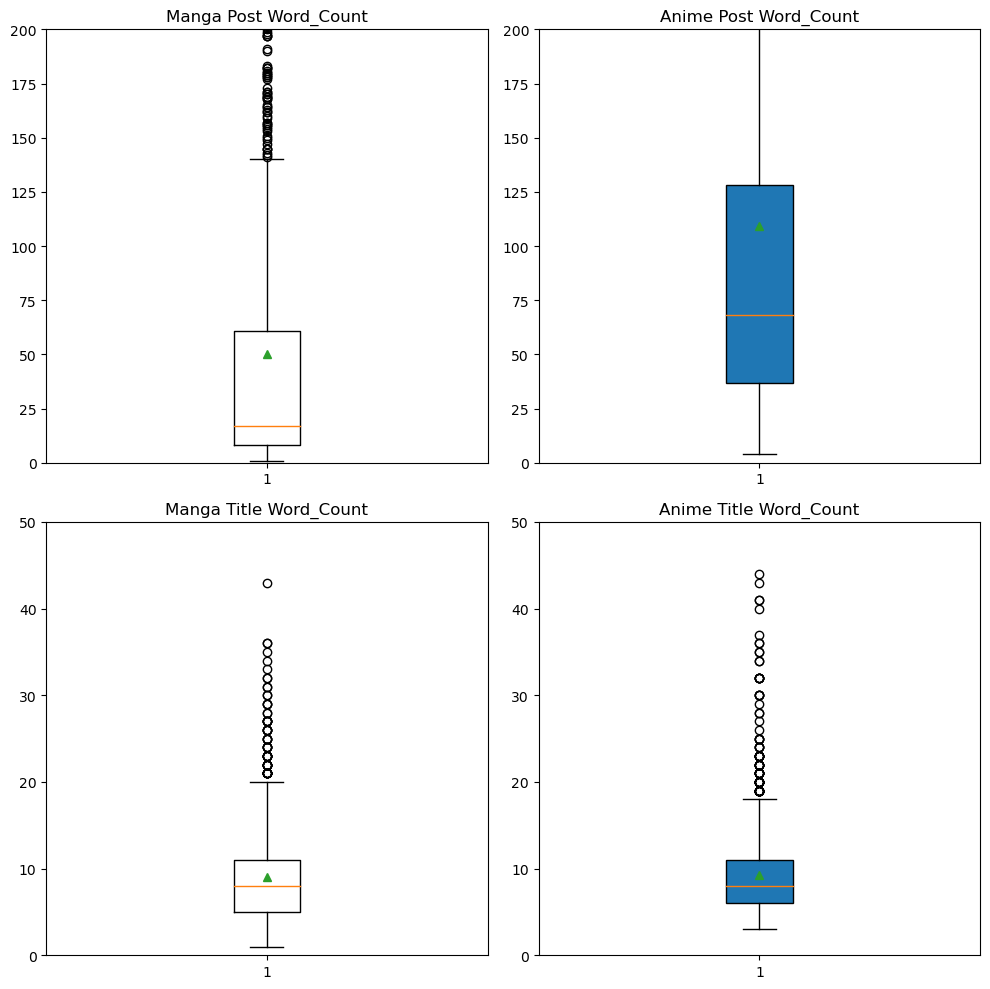

In [44]:
#Since the following is really from the EDA stage, I feel like I'll make the graphs for the word count post/titles here:
plt.figure(figsize=(10, 10))

ax1 = plt.subplot(2,2,1)
ax1.boxplot(df[df['subreddit'] ==0]['word_count_post'], showmeans=True)
ax1.set_ylim(0, 200)
ax1.set_title("Manga Post Word_Count")

ax2 = plt.subplot(2,2,2)
ax2.boxplot(df[df['subreddit'] ==1]['word_count_post'], showmeans=True, patch_artist=True)
ax2.set_ylim(0, 200)
ax2.set_title("Anime Post Word_Count")

ax3 = plt.subplot(2,2,3)
ax3.boxplot(df[df['subreddit'] ==0]['word_count_title'], showmeans=True)
ax3.set_ylim(0, 50)
ax3.set_title("Manga Title Word_Count")

ax4 = plt.subplot(2,2,4)
ax4.boxplot(df[df['subreddit'] ==1]['word_count_title'], showmeans=True, patch_artist=True)
ax4.set_ylim(0, 50)
ax4.set_title("Anime Title Word_Count")

plt.tight_layout();